# AdPMCMC on model $M_0$ to $M_2$

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

import scipy
from scipy.stats import invgamma
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn
%pylab inline

from tqdm import tqdm 

# Homemade functions
from utils import process_date, gaussian_log_density, stratified_resampling, gaussian_kernel_density, equation
from trajectorySimulation import trajectory_simulation
from SMC import SMC
from AdPMCMC import AdPMCMC_M0, AdPMCMC_M2

Populating the interactive namespace from numpy and matplotlib


We begin by considering the model $M_0$ : 
\begin{equation}
\log N_{t+1} = \log N_t + b_0 + \epsilon_t
\end{equation}

with $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$. 

We put a Gaussian prior on the maximum per-individual growth rate parameter : $b_0 \sim \mathcal{N}(0, 1)$.
We use inverse Gamma priors for the variance noises :

$\sigma_\epsilon^2 \sim \mathcal{IG}(\alpha_\epsilon, \beta_\epsilon)$

$\sigma_w^2 \sim \mathcal{IG}(\alpha_w, \beta_w)$

with hyperpameters $\alpha_\epsilon=\alpha_w=\frac{T}{2}$ and $\beta_\epsilon=\beta_w=\frac{2(\alpha_\epsilon-1)}{10}$.

## MCMC kernel for $\theta$

In [2]:
from kernels import non_adaptive_theta_proposal, adaptive_theta_proposal

## SMC sampler for $n_{1:T}$

In the paper, there seems to be a simulation of $b_0$ per particles, see Algorithm 1, p.31, this seems odd.

See "Log-PF: Particle Filtering in Logarithm Domain" for log-normalization of weights
Need to check initialisation for other models than M_0

In [3]:
def SMC(Y, T, L, N_0, model, SigmaEps , SigmaW, B_0=0 , B_1=0 , B_2=0 , B_3=0 , B_4=0):
    """
    Particle filter for M0 model
    y : observation trajectory
    T : time horizon
    L : number of particles
    n_0 : initial value of latent variable
    b_0, sigma_eps, sigma_w : M0 parameters
    """
    
    # Initialization of log particles and log-weights matrix
    LogParticles = np.zeros((T, L))
    LogW = np.zeros((T, L))
    
    # Initialization of likelihood matrix 
    # Contains the obs likelihood for each particle
    w = np.zeros((T, L))
    
    # Initialization : check if OK for other models than M
    LogParticles[0, :] = np.log(N_0)
    
    # Log-weight computation
    for l in range(L):
        w[0, l] = gaussian_log_density(Y[0], LogParticles[0, l], SigmaW)
        LogW[0, l] = w[0, l]
    
    # Log-weight normalization
    LogW[0, :] -= np.max(LogW[0, :]) # scaling   
    LogSumOfWeights = np.log(sum(np.exp(LogW[0, :]))) 
    LogW[0, :] -= LogSumOfWeights
        
    for t in range(1, T):
        for l in range(L):
            # Propagation
            #LogParticles[t, l] = LogParticles[t-1, l] + B_0 + np.random.normal(0, SigmaEps)
            LogParticles[t, l] = equation(LogParticles[t-1, l],model,SigmaEps,B_0,B_1,B_2,B_3,B_4)
        
            # Log-weight computation
            w[t, l] = gaussian_log_density(Y[t], LogParticles[t, l], SigmaW)
            LogW[t, l] = LogW[t-1, l] + w[t, l]
                
        # Weight normalization (log scale)
        LogW[t, :] -= np.max(LogW[t, :]) # scaling   
        LogSumOfWeights = np.log(sum(np.exp(LogW[t, :]))) 
        LogW[t, :] -= LogSumOfWeights
                            
        # Adaptive resampling : sample if ESS < 80% of number of particles
        ESS = 1/sum(np.exp(LogW[t, :])**2)
                        
        if ESS < 0.8*L:
            # resample indexes according to the normalized importance weights
            ResampledIndexes = stratified_resampling(np.exp(LogW[t, :]))
            LogParticles[t, :] = LogParticles[t, ResampledIndexes]
            LogW[t, :] = np.log(np.ones(L)/L) # the new particles have equal weight
                
    # Evaluate marginal likelihood
    
    LogMarginalLikelihood = np.sum(np.log(np.sum(np.exp(w), axis=1)/L))     
        
    return LogParticles, LogW, LogMarginalLikelihood

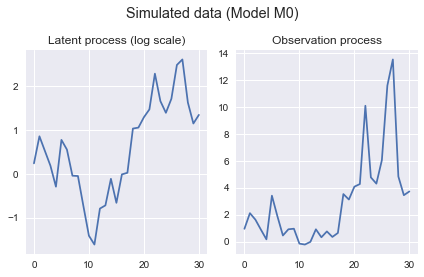

In [18]:
# Model choice and general model parameters
model='M0'
b_0 = 0.15
b_2 = -0.125
b_3 = 0.1
sigma_w = 0.39 # observation noise
sigma_eps = 0.47 # process noise
n_0 = 1.27 # starting point of latent variable
T = 30 # time horizon

# Simulate and plot a trajectory
log_N, Y = trajectory_simulation(model = model, T=T, n_0=n_0, b_0=b_0,b_2=b_2,b_3=b_3,
                                sigma_eps=sigma_eps, sigma_w=sigma_w)

f, (ax1, ax2) = plt.subplots(1, 2)
st = f.suptitle("Simulated data (Model "+model+")", fontsize="x-large")

ax1.plot(log_N)
ax1.set_title('Latent process (log scale)')
ax2.plot(Y)
ax2.set_title('Observation process')

plt.tight_layout()

st.set_y(0.95)
f.subplots_adjust(top=0.80)

-57.1031637188


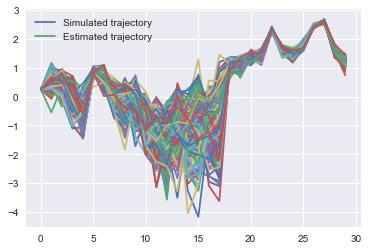

In [19]:
L = 500 # number of particles

log_particles, log_W, log_marginal_likelihood = SMC(Y, T, L, n_0,model,sigma_eps, sigma_w,B_0=b_0,B_2=b_2,B_3=b_3)

log_particles_averaged = [np.average(log_particles[t, :], weights=np.exp(log_W[t, :]), axis=0) 
                          for t in range(T)]

plt.plot(log_N[:-1])
plt.plot(log_particles) 
plt.legend(["Simulated trajectory", "Estimated trajectory"])
print(log_marginal_likelihood)

## Stage 3 : Generic PMCMC

In [40]:
n_steps = 10000 # number of iterations 
L = 300 # number of particles
adaptive_rate = 0.5  # adaptive rate (set to 0 for non-adaptive proposal)

theta_hist_M0 = AdPMCMC_M0(n_steps, T, adaptive_rate, Y, L, n_0)

Running AdPMCMC:   0%|          | 4/10000 [00:00<12:42, 13.10it/s]

Number of inf log-likelihood : 0 ; Number of accepted samples : 2


Running AdPMCMC:   5%|▌         | 502/10000 [00:48<15:14, 10.38it/s]

Number of inf log-likelihood : 0 ; Number of accepted samples : 327


Running AdPMCMC:  10%|█         | 1002/10000 [01:38<14:40, 10.22it/s]

Number of inf log-likelihood : 10 ; Number of accepted samples : 367


Running AdPMCMC:  15%|█▌        | 1503/10000 [02:19<13:08, 10.77it/s]

Number of inf log-likelihood : 39 ; Number of accepted samples : 435


Running AdPMCMC:  20%|██        | 2002/10000 [03:05<12:22, 10.77it/s]

Number of inf log-likelihood : 68 ; Number of accepted samples : 458


Running AdPMCMC:  25%|██▌       | 2502/10000 [03:51<11:33, 10.81it/s]

Number of inf log-likelihood : 97 ; Number of accepted samples : 517


Running AdPMCMC:  30%|███       | 3001/10000 [04:35<10:41, 10.90it/s]

Number of inf log-likelihood : 110 ; Number of accepted samples : 573


Running AdPMCMC:  35%|███▌      | 3503/10000 [05:18<09:49, 11.01it/s]

Number of inf log-likelihood : 139 ; Number of accepted samples : 638


Running AdPMCMC:  40%|████      | 4003/10000 [06:00<08:59, 11.11it/s]

Number of inf log-likelihood : 157 ; Number of accepted samples : 694


Running AdPMCMC:  45%|████▌     | 4502/10000 [06:42<08:11, 11.18it/s]

Number of inf log-likelihood : 175 ; Number of accepted samples : 763


Running AdPMCMC:  50%|█████     | 5002/10000 [07:23<07:23, 11.28it/s]

Number of inf log-likelihood : 187 ; Number of accepted samples : 838


Running AdPMCMC:  55%|█████▌    | 5502/10000 [08:03<06:35, 11.37it/s]

Number of inf log-likelihood : 203 ; Number of accepted samples : 917


Running AdPMCMC:  60%|██████    | 6002/10000 [08:44<05:49, 11.44it/s]

Number of inf log-likelihood : 220 ; Number of accepted samples : 953


Running AdPMCMC:  65%|██████▌   | 6502/10000 [09:25<05:04, 11.50it/s]

Number of inf log-likelihood : 241 ; Number of accepted samples : 978


Running AdPMCMC:  70%|███████   | 7002/10000 [10:05<04:19, 11.56it/s]

Number of inf log-likelihood : 253 ; Number of accepted samples : 989


Running AdPMCMC:  75%|███████▌  | 7502/10000 [10:46<03:35, 11.60it/s]

Number of inf log-likelihood : 275 ; Number of accepted samples : 1054


Running AdPMCMC:  80%|████████  | 8003/10000 [11:29<02:51, 11.61it/s]

Number of inf log-likelihood : 288 ; Number of accepted samples : 1114


Running AdPMCMC:  85%|████████▌ | 8503/10000 [12:09<02:08, 11.65it/s]

Number of inf log-likelihood : 306 ; Number of accepted samples : 1152


Running AdPMCMC:  90%|█████████ | 9003/10000 [12:50<01:25, 11.69it/s]

Number of inf log-likelihood : 329 ; Number of accepted samples : 1189


Running AdPMCMC:  95%|█████████▌| 9503/10000 [13:30<00:42, 11.72it/s]

Number of inf log-likelihood : 348 ; Number of accepted samples : 1264


Running AdPMCMC: 100%|██████████| 10000/10000 [14:11<00:00, 11.74it/s]

Number of samples : 1314


In [44]:
theta_hist_M2 = AdPMCMC_M2(n_steps, T, adaptive_rate, Y, L, n_0)

Running AdPMCMC:   0%|          | 2/10000 [00:00<18:07,  9.19it/s]

Number of inf log-likelihood : 0 ; Number of accepted samples : 2


Running AdPMCMC:   5%|▌         | 502/10000 [00:53<16:51,  9.39it/s]

Number of inf log-likelihood : 0 ; Number of accepted samples : 358


Running AdPMCMC:  10%|█         | 1002/10000 [01:44<15:39,  9.58it/s]

Number of inf log-likelihood : 11 ; Number of accepted samples : 496


Running AdPMCMC:  15%|█▌        | 1502/10000 [02:34<14:32,  9.74it/s]

Number of inf log-likelihood : 28 ; Number of accepted samples : 578


Running AdPMCMC:  20%|██        | 2004/10000 [03:25<13:38,  9.77it/s]

Number of inf log-likelihood : 50 ; Number of accepted samples : 651


Running AdPMCMC:  25%|██▌       | 2502/10000 [04:14<12:42,  9.84it/s]

Number of inf log-likelihood : 67 ; Number of accepted samples : 742


Running AdPMCMC:  30%|███       | 3003/10000 [05:04<11:50,  9.85it/s]

Number of inf log-likelihood : 82 ; Number of accepted samples : 799


Running AdPMCMC:  35%|███▌      | 3502/10000 [05:53<10:56,  9.90it/s]

Number of inf log-likelihood : 160 ; Number of accepted samples : 857


Running AdPMCMC:  40%|████      | 4002/10000 [06:42<10:03,  9.93it/s]

Number of inf log-likelihood : 204 ; Number of accepted samples : 934


Running AdPMCMC:  45%|████▌     | 4503/10000 [07:31<09:11,  9.96it/s]

Number of inf log-likelihood : 251 ; Number of accepted samples : 1031


Running AdPMCMC:  50%|█████     | 5002/10000 [08:20<08:20,  9.99it/s]

Number of inf log-likelihood : 312 ; Number of accepted samples : 1093


Running AdPMCMC:  55%|█████▌    | 5502/10000 [09:09<07:29, 10.01it/s]

Number of inf log-likelihood : 379 ; Number of accepted samples : 1152


Running AdPMCMC:  60%|██████    | 6002/10000 [10:00<06:39, 10.00it/s]

Number of inf log-likelihood : 466 ; Number of accepted samples : 1249


Running AdPMCMC:  65%|██████▌   | 6502/10000 [10:51<05:50,  9.97it/s]

Number of inf log-likelihood : 522 ; Number of accepted samples : 1335


Running AdPMCMC:  70%|███████   | 7002/10000 [11:58<05:07,  9.75it/s]

Number of inf log-likelihood : 592 ; Number of accepted samples : 1408


Running AdPMCMC:  75%|███████▌  | 7502/10000 [12:58<04:19,  9.64it/s]

Number of inf log-likelihood : 647 ; Number of accepted samples : 1475


Running AdPMCMC:  80%|████████  | 8002/10000 [13:51<03:27,  9.63it/s]

Number of inf log-likelihood : 697 ; Number of accepted samples : 1544


Running AdPMCMC:  85%|████████▌ | 8502/10000 [14:46<02:36,  9.59it/s]

Number of inf log-likelihood : 724 ; Number of accepted samples : 1597


Running AdPMCMC:  90%|█████████ | 9002/10000 [15:45<01:44,  9.52it/s]

Number of inf log-likelihood : 761 ; Number of accepted samples : 1677


Running AdPMCMC:  95%|█████████▌| 9502/10000 [16:44<00:52,  9.46it/s]

Number of inf log-likelihood : 770 ; Number of accepted samples : 1754


Running AdPMCMC: 100%|██████████| 10000/10000 [17:42<00:00,  9.41it/s]

Number of samples : 1815


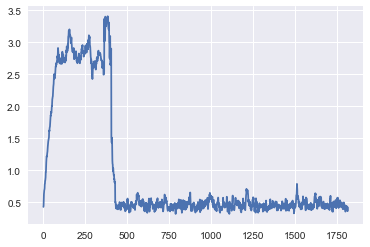

In [71]:
# burn-in time
theta_history_M0 = np.array(theta_hist_M0[:])
theta_history_M2 = np.array(theta_hist_M2[:])
plt.plot(theta_history_M2[:,4])
savefig('values_sigma_w_10k_300p_M2')

0.492489805234


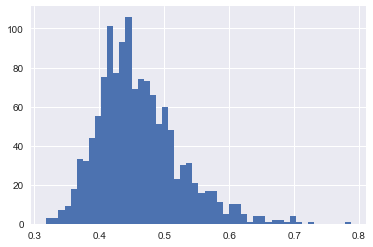

In [90]:
plt.hist(theta_history_M2[500:, 4], bins=50)
print(theta_history_M0[:,1].mean())
#plt.title('Posterior density for b_0')
savefig('posterior_sigma_w_10k_300p_M2_burn500')

# Real data

We load the nutria database and plot the trajcetory of the myocastor coypus population :

In [91]:
df = pd.read_csv('nutria_data.csv')
df['YearMonth'] = df['TimeOfSample'].apply(process_date)
df.head()

,TaxonName,MainID,TimeOfSample,Population,Abundance,YearMonth
0,Myocastor coypus,9833,1970.01,0.55,550,719163.0
1,Myocastor coypus,9833,1970.02,0.55,550,719194.0
2,Myocastor coypus,9833,1970.03,0.60,600,719222.0
3,Myocastor coypus,9833,1970.04,0.55,550,719253.0
4,Myocastor coypus,9833,1970.05,0.50,500,719283.0


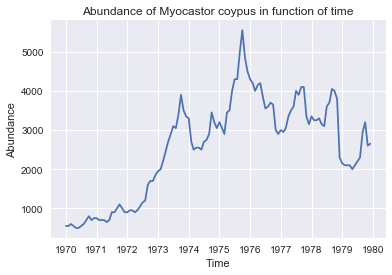

In [92]:
plt.plot_date(df["YearMonth"],df["Abundance"], '-')
plt.title('Abundance of Myocastor coypus in function of time')
plt.xlabel('Time')
plt.ylabel('Abundance')

-299.337344414


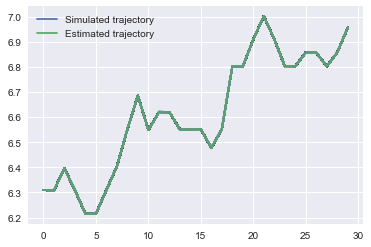

In [93]:
Y_nutria = df["Abundance"].tolist()
n_0_nutria = Y_nutria[0] 

L = 500 # number of particles
#def SMC(Y, T, L, N_0, model, SigmaEps , SigmaW, B_0=0 , B_1=0 , B_2=0 , B_3=0 , B_4=0):

log_particles, log_W, log_marginal_likelihood = SMC(Y_nutria, T, L, n_0_nutria,'M0',sigma_eps, sigma_w,B_0=b_0,B_2=b_2,B_3=b_3)

log_particles_averaged = [np.average(log_particles[t, :], weights=np.exp(log_W[t, :]), axis=0) 
                          for t in range(T)]

#plt.plot(log_N[:-1])
plt.plot(log_particles) 
plt.legend(["Simulated trajectory", "Estimated trajectory"])
print(log_marginal_likelihood)

In [94]:
n_steps = 1000
L = 300

# adaptive rate 
adaptive_rate = 0.5  # set to 0 -> non-adaptive proposal

theta_hist_nutria = AdPMCMC_M0(n_steps, T, adaptive_rate, Y_nutria, L, n_0_nutria)

Running AdPMCMC:   0%|          | 3/1000 [00:00<01:28, 11.25it/s]

Number of inf log-likelihood : 1 ; Number of accepted samples : 2


Running AdPMCMC:   3%|▎         | 31/1000 [00:02<01:21, 11.83it/s]


KeyboardInterrupt: 

In [ ]:
# burn-in time
theta_history = np.array(theta_hist_nutria[0:])

plt.plot(theta_history[:, 0])